In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.stats.proportion import proportion_confint

import utils

plt.style.use(
    [
        "tableau-colorblind10",
        utils.get_style("default"),
        utils.get_style("1-col"),
    ]
)

In [3]:
def generate_fancy_plots(
    df: pd.DataFrame, 
    adv_name: str,
    highlighted_victim_steps = None,
    skip_legend: bool = False,
    custom_legend_label: str = "",
    custom_xlabel: str | None = None,
    custom_ylabel: str | None = None,
    vv_filter: list[int] | None = None,
):
    ALPHA = 0.05
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    for i, vv in enumerate(sorted(df.victim_visits.unique())):
        if vv_filter is not None and vv not in vv_filter:
            continue

        sub_df = df.query(
            "&".join(
                [
                    "victim_visits == @vv",
                    "adv_name == @adv_name",
                ]
            )
        )
        mean_df = sub_df.groupby("victim_steps").adv_win.mean()

        (100 * mean_df).plot(label=f"{custom_legend_label}{vv}", color=colors[i])

        # Compute Clopper-Pearson confidence intervals
        ci_df = sub_df.groupby("victim_steps").adv_win.apply(
            lambda x: proportion_confint(
                x.sum(),
                len(x),
                alpha=ALPHA,
                method="beta",
            )
        )
        ci_df = pd.DataFrame(
            ci_df.tolist(), index=ci_df.index, columns=["lower", "upper"]
        )
        ci_df = 100 * ci_df
        plt.fill_between(
            mean_df.index,
            ci_df.lower,  # type: ignore
            ci_df.upper,  # type: ignore
            alpha=0.3,
            color=colors[i],
            edgecolor="none",
        )

        if highlighted_victim_steps:
            plt.plot(
                highlighted_victim_steps,
                100 * sub_df.query("victim_steps == @highlighted_victim_steps").adv_win.mean(),
                "D",
                color=colors[i],
                alpha=0.7,
            )
    # Legend in lower left corner
    if not skip_legend:
        plt.legend()
    plt.ylabel(
        custom_ylabel or r"Win rate \%"
    )
    plt.xlabel(custom_xlabel or rf"KataGo training steps")

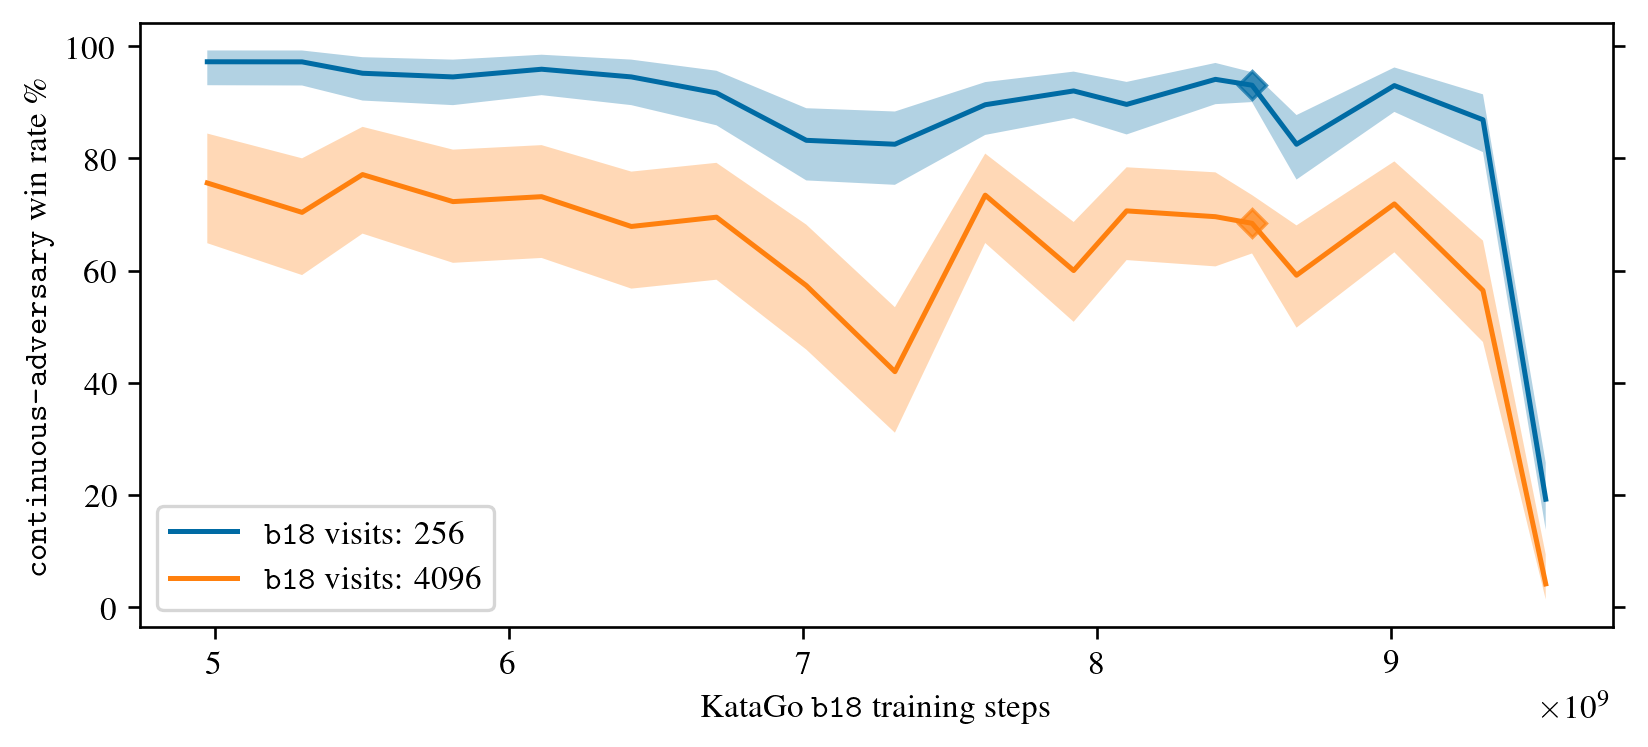

In [4]:
# TODO regen when cont sweeps finish
df = utils.parse_sgfs(["/shared/match/ttseng-cont-sweeps-240313/b18-ckpts"])
generate_fancy_plots(
    df, 
    adv_name="adv-s630461952-v600-AMCTS",
    highlighted_victim_steps=8526915840,
    custom_legend_label=r"\texttt{b18} visits: ",
    custom_xlabel=r"KataGo \texttt{b18} training steps",
    custom_ylabel=r"\texttt{continuous-adversary} win rate \%",
)

In [ ]:
def swap_adv_and_victim(df: pd.DataFrame):
    to_swap = ["color", "name", "visits", "steps", "rsym", "algo"]
    for col in to_swap:
        col1 = f"victim_{col}"
        col2 = f"adv_{col}"
        df[col1], df[col2] = df[col2], df[col1]
    nums_to_negate = ["adv_komi", "adv_minus_victim_score", "adv_minus_victim_score_wo_komi"]
    for col in nums_to_negate:
        df[col] = -df[col]
    df["adv_win"] = ~df["adv_win"]

VIT_B4_MAX_STEPS = 213218816
VIT_B8_MAX_STEPS = 553885440
# (architecture, step offset, highlighted step)
df = utils.parse_sgfs(
    f"/shared/match/ttseng-vit-selfplay-240314/{name}"
    for name in ["vit-b4", "vit-b8", "vit-b16"]
)
# Adversaries and victims are swapped in these data, let's unswap everything
swap_adv_and_victim(df)
print(df)


#df = df[df["victim_steps"] < 217500000] # vit-b4 nets above s217m are bad

df["arch"] = df["sgf_path"].split("/")

generate_fancy_plots(
    df, 
    adv_name="attack-vit-s326m",
    custom_legend_label=r"\texttt{vit-b4} visits: ",
    custom_xlabel=r"\texttt{vit-b4} training steps",
    custom_ylabel=r"\texttt{attack-vit} win rate \%",
)
generate_fancy_plots(
    df, 
    adv_name="cyclic-s545m",
    custom_legend_label=r"\texttt{vit-b4} visits: ",
    custom_xlabel=r"\texttt{vit-b4} training steps",
    custom_ylabel=r"\texttt{base-adversary} win rate \%",
)